In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

In [4]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [5]:
n = 1000
min_f = -4 # normalized to 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=3,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 3)


In [6]:
x_train.shape

(1000, 100, 3, 1)

In [7]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 3, 1), 900]

In [8]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 3)


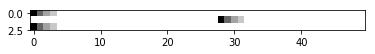

m (50, 3)


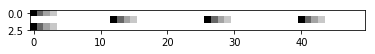

m (50, 3)


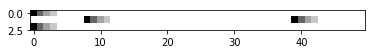

In [9]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 3, 1)

In [11]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [12]:
def encoder(input_size, dropout=0.1):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    #     x = AveragePooling2D((2, 2))(x)
#     h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)
    
#     x = Reshape((-1, 1, 1))(x)

    h = Reshape((-1, intermediate_dim))(h)
    n_capsules = 10
    capsule_dim = 10
    n_routings = 3
    share_weights = True
    h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)

    # h = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(h)
    h = Reshape((n_capsules * capsule_dim,))(h)
    
    # Z Mean, Variance - no activation? TODO
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [13]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

shared weights, shape = (1, 128, 100) 12800
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 3)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 32)       224         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 32)       2080        conv1d_1[0][0]                   
_________________________________________________________________

In [14]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [15]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [16]:
def list_decoders(output_shape, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolution
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#    # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    # h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [17]:
decoders = list_decoders(input_shape)

In [18]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [19]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 232852      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          384         lambda_2[0][0]                   
__________

In [20]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.2)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_4" during training.
  # This is added back by InteractiveShellApp.init_path()


In [21]:
# train the VAE on MNIST digits
# (x_train, _), (x_test, y_test) = mnist.load_data()

In [22]:
x_train.shape

(900, 100, 3, 1)

In [23]:
print('x_train.shape:', x_train.shape)

x_train.shape: (900, 100, 3, 1)


In [24]:
batch_size = 100
epochs = 100
params = {'batch_size': batch_size, 'return_y': False}

In [25]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [26]:
m = 4
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>\n' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
#     history = vae.fit_generator(
#         X, epochs=epochs, steps_per_epoch=X.__len__(),
#         use_multiprocessing=True, workers=2,
#         validation_data=(x_test, None))
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 2s 441ms/step - loss: 208.2779
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 204.2711
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 198.0673
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 175.8706
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 146.3057
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 116.7261
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 103.7183
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 96.9944
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 96.0401
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 61.4204

[Epoch 1/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==========


[Epoch 9/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 63.0842
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 53.2228
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 52.0505
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 50.0054
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 47.8416
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 51.5887
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 59.6788
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 49.3528
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 57.8062
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 55.1210

[Epoch 10/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 48.9051
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 59.4839
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 50.9768
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 50.9914
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 49.2869
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 50.2519
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 46.1182
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 45.7383
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 50.0025
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 49.7038

[Epoch 19/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 46.2098
 Batch 1/9
Epoch 1/1
4/

 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 56.6132
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 39.3790
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 38.7517
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 52.0677
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 51.5074
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 45.7521
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 42.8048
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.8439
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 61.2727

[Epoch 28/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 41.2522
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 43.4971
 B

4/4 [==============================] - 0s 2ms/step - loss: 38.7126
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 38.0016
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.8375
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 47.0606
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 44.9327
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 39.7121
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.6324
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 37.6609
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.4318

[Epoch 37/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 40.5498
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.9922
 Batch 2/9
Epoch 1/1
4/

 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 34.1254
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 37.9363
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.0220
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.9182
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.9833
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 36.7038
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 42.6728
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 36.9122

[Epoch 46/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 36.0335
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 39.3625
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.6806
 B

4/4 [==============================] - 0s 2ms/step - loss: 32.1325
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.7503
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 38.9188
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.1017
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.0971
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.8991
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 37.3334
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 37.8130

[Epoch 55/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 38.6615
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.0597
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.4045
 Batch 3/9
Epoch 1/1
4/

 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.8064
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.2432
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.8172
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.2754
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.0284
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.9534
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 36.8985

[Epoch 64/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 31.6962
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.9693
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.4716
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.1381
 B

4/4 [==============================] - 0s 2ms/step - loss: 36.0057
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.4626
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.7838
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.2081
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.6611
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.4344
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 34.4247

[Epoch 73/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 32.1206
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.9860
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.4134
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 37.8203
 Batch 4/9
Epoch 1/1
4/

 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.9070
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.4008
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 36.7744
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.1251
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 30.5029
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.6402

[Epoch 82/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.2055
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 31.5226
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.6191
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 31.5266
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 52.7965
 B

4/4 [==============================] - 0s 2ms/step - loss: 31.2445
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.1647
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 39.2850
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 31.1588
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 31.7170
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 30.5345

[Epoch 91/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 31.2530
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.5829
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 32.0005
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 31.4303
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 34.1386
 Batch 5/9
Epoch 1/1
4/

 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 36.4269
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 35.4963
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 34.7422
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 33.9718
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 28.6803


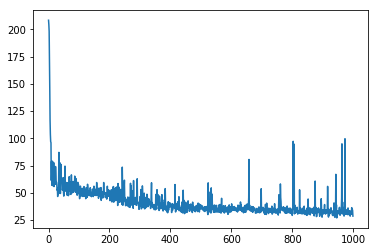

In [27]:
# x = epochs * batches
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [28]:
# datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
# x = datagen.standardize(x_train[:10])
# i = 0
# plot.single(x_train[i, :50, :, 0])
# plot.single(x[i, :50, :, 0])

m (50, 3)


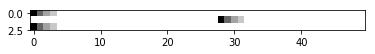

m (50, 3)


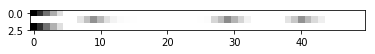

m (50, 3)


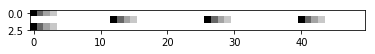

m (50, 3)


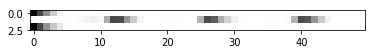

In [29]:
i = 0
j = 1
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])

In [30]:
x.shape

(10, 100, 3, 1)

m (30, 3)


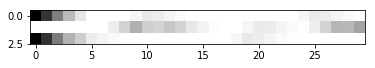

In [31]:
# interpolate - mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

m (30, 3)


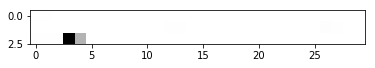

In [32]:
# interpolate - min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [33]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [34]:
x_test.shape

(100, 100, 3, 1)

In [35]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

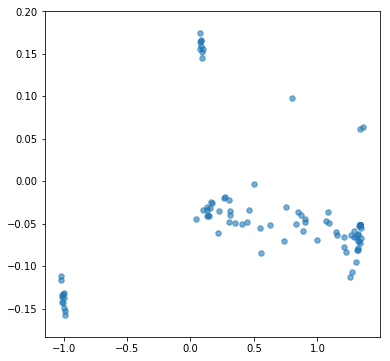

In [42]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.6, s=30) # c=y_test

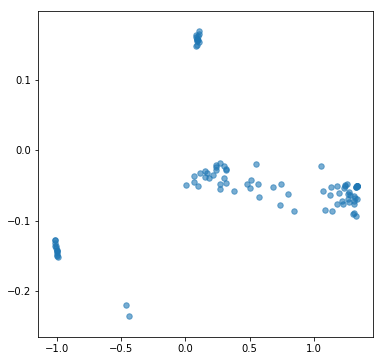

In [43]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30)
# plt.colorbar()

In [38]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [95]:
def latent(generator,
           batch_size=2,
           latent_dim=2,
           x_encoded=0.,
           latent_indices=(0, 1),
           n=10,
           m=4,
           crop_size=30,
           margin_top=1,
           margin_left=1,
           min_x=0.05,
           max_x=0.95,
           min_y=0.05,
           max_y=0.95):
    """ Original: keras.keras.examples.variational_autoencoder
    :x_encoded :: float | [ float ]
    
    to swap x,y set `latent_indices`` to (1,0)
    """
    if not isinstance(x_encoded, np.ndarray):
        x_encoded = np.repeat(x_encoded, latent_dim)
    x_decoded = generator.predict(x_encoded.reshape([1, latent_dim]))

    # display a 2D manifold of output samples
    size1 = x_decoded.shape[2]
    size2 = crop_size  # crop x_train.shape[1]
    margin_y, margin_x = n * margin_top * 3, m * margin_left * 3
    figure = np.zeros((size1 * n + margin_y, size2 * m + margin_x))
    # linearly spaced coordinates on the unit square were transformed through
    # the inverse CDF (ppf) of the Gaussian to produce values of the latent
    # variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(min_x, max_x, n))
    grid_y = norm.ppf(np.linspace(min_y, max_y, m))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = x_encoded.copy()
            z_sample[np.array(latent_indices)] = (xi, yi)
            # z_sample = np.array([[yi, xi]])
            # TODO check whether batch_size influences the generator output
            z_sample = np.tile(z_sample, batch_size).reshape(
                batch_size, latent_dim)
            x_decoded = generator.predict(z_sample, batch_size=batch_size)
            sample = x_decoded[0, :size2].reshape((size2, size1)).transpose()
            sample.reshape(size1, size2)
            # coordinates of the current sample
            a = i * size1 + i * margin_top * 3
            b = (i + 1) * size1 + i * margin_top * 3
            c = j * size2 + j * margin_left * 3
            d = (j + 1) * size2 + j * margin_left * 3
            # table separators (partially overlapping)
            figure[a, :] = 0
            figure[a + 1, 1:-1] = 0.3
            figure[a + 2, :] = 0
            figure[:, c] = 0
            figure[1:, c + 1] = 0.3
            figure[:, c + 2] = 0
            a, b, c, d = a + 3, b + 3, c + 3, d + 3
            figure[a:b, c:d] = sample

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray_r')
    plt.show()

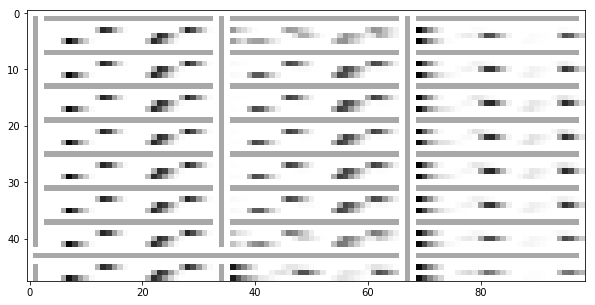

In [105]:
min_y = 0.01
max_y = 0.5
latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

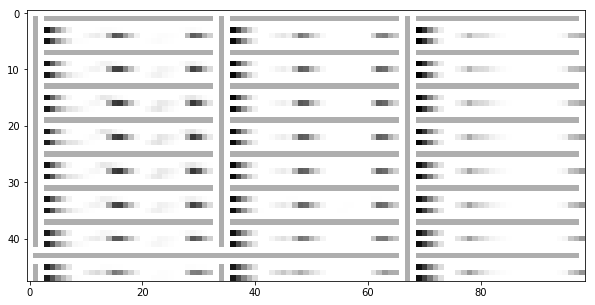

In [106]:
min_y2 = max_y
latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)